In [1]:
from __future__ import print_function
import pickle 
import argparse
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import copy
import torch.optim as optim
#from torchvision import datasets, transforms
from torch.autograd import Variable

In [2]:
trainset_labeled = pickle.load(open("train_labeled.p", "rb")) 
train_loader  = torch.utils.data.DataLoader(trainset_labeled, batch_size=64, shuffle=True, num_workers=2)

validset = pickle.load(open("validation.p", "rb"))
valid_loader = torch.utils.data.DataLoader(validset, batch_size=64, shuffle=True, num_workers=2)

Files already downloaded
3000
750


In [3]:
train_numpy = trainset_labeled.train_data.numpy()
#train_numpy = np.concatenate((train_numpy, train_numpy),0)
train_labels_numpy = trainset_labeled.train_labels.numpy()
#train_labels_numpy = np.concatenate((train_labels_numpy, train_labels_numpy),0)

In [4]:
train_numpy

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ..., 
       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, 

In [5]:
train_numpy_reshaped = train_numpy.reshape(-1, 784)
all_black = np.max(train_numpy_reshaped,1) == 0
print(all_black.any())

False


In [6]:
np.max(train_numpy_reshaped,1).min()

254

In [7]:


train_shifted = copy.copy(train_numpy)
train_labeled_shifted = copy.copy(train_labels_numpy)
train_numpy.shape
for hshift in range(-4,6,2):
    for vshift in range(-4,6,2):
        next_shift = np.concatenate((np.zeros((3000,np.max((0,-1*vshift)),28)),
                                      train_numpy[:,np.max((0,vshift)):np.min((28,28+vshift)),:],
                                      np.zeros((3000,np.max((0,vshift)),28))),1)
        
        next_shift = np.concatenate((np.zeros((3000,28,np.max((0,-1*hshift)))),
                                      next_shift[:,:,np.max((0,hshift)):np.min((28,28+hshift))],
                                      np.zeros((3000,28,np.max((0,hshift))))),2)
        
        train_shifted = np.concatenate((train_shifted, next_shift))
        train_labeled_shifted = np.concatenate((train_labels_numpy, train_labeled_shifted))

In [8]:
train_shifted_reshaped = train_shifted.reshape(-1, 784)
print(train_shifted_reshaped.shape)
all_black = np.max(train_shifted_reshaped,1) == 0
print(all_black.any())

(78000, 784)
False


In [9]:
print(np.isnan(train_shifted).any(), np.isinf(train_shifted).any(), np.max(train_shifted), np.min(train_shifted))

False False 255.0 0.0


In [10]:
train_labels_numpy.shape

(3000,)

In [11]:
type(train_shifted)

numpy.ndarray

In [12]:
train_shifted[0].shape

(28, 28)

In [30]:
trainset_labeled = torch.utils.data.TensorDataset(
    torch.FloatTensor(train_shifted) / 255.,
    torch.LongTensor(train_labeled_shifted)
    )

train_loader  = torch.utils.data.DataLoader(trainset_labeled, batch_size=64, shuffle=True, num_workers=2)

In [14]:
x = trainset_labeled.train_data[1]

AttributeError: 'TensorDataset' object has no attribute 'train_data'

In [15]:
dir(trainset_labeled)

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__getitem__',
 '__hash__',
 '__init__',
 '__len__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'data_tensor',
 'target_tensor']

In [16]:
trainset_labeled.train_data.size()

AttributeError: 'TensorDataset' object has no attribute 'train_data'

In [17]:
trainset_labeled.train_data.size()

AttributeError: 'TensorDataset' object has no attribute 'train_data'

0


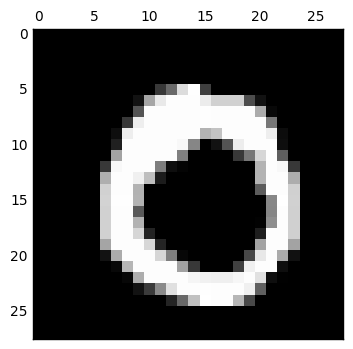

In [19]:
%matplotlib inline
import matplotlib.pyplot as PL
i = 5
PL.matshow(trainset_labeled.data_tensor[i].numpy(), vmin=0, vmax=255, cmap='gray')
print(trainset_labeled.target_tensor[i])

In [20]:
#utility functions
def rand(x, level = 1e-3):
    return x + torch.randn(x.size()) * level

def norm_weights_2d(size):
    return BatchNorm2d(nn.Linear(size))
def norm_weights_1d(size):
    return BatchNorm2d(nn.Linear(size))

def reluN(x, level = 1e-3):
    y = x + torch.randn(x.size()) * level

In [21]:
def norm(size, dim = 1):
    if dim == 1:
        return torch.nn.BatchNorm1d(size)
    else:
        return torch.nn.BatchNorm2d(size)

    
def vect_std(tens):
    tens_mean = tens.mean(0)
    length = tens.size()[0]
    return  ((tens - broad(tens_mean, length))**2).sum(0).sqrt()/ (length-1) + 1e-8

def linear(indim, outdim):
    return nn.Linear(indim, outdim)
def var(tens):
    # The whole torch.nn module uses Parameter objects, which are essentially wrappers
    # of autograd Variables.
    return torch.nn.Parameter(tens)
def randn(size):
    return torch.randn(size)
def matmul(w1, w2):
    return w1.mm(w2)

def broad(tens, bs):
    size = list(tens.size())
    return tens.unsqueeze(0).expand(*([bs] + size))

def expand(tens, bs):
    size = list(tens.size())[1:]
    return tens.expand(*([bs] + size))

def anynan(x):
    return nan(x) or inf(x) or big(x)

def nan(x):
    return np.isnan(x.data.numpy()).any()

def inf(x):
    return np.isinf(x.data.numpy()).any()

def big(x):
    return (np.abs(x.data.numpy()) > 1e+5).any()

class Net(nn.Module):
    def u(self, v, z):
        
        return self.normalize_vector(v(z))
    
    def normalize_vector(self, vect):
        bs = vect.size()[0]
        vectmean = vect.mean(0)
        vectstd = vect_std(vect)
        assert not anynan(vectmean)
        assert not anynan(vectstd)
        vznorm = (vect - broad(vectmean, bs)) / broad(vectstd, bs)
        assert not anynan(vznorm)
        return vznorm
    
    def normalize_vector_noise(self, vect, noise):
        bs = vect.size()[0]
        vectmean = vect.mean(0)
        vectstd = vect_std(vect)
        assert not anynan(vectmean)
        assert not anynan(vectstd)
        vznorm = (vect - broad(vectmean, bs)) / broad(vectstd, bs)
        assert not anynan(vznorm)
        return vznorm + noise
    
    
        
    def mu_v(self, u, a1, a2, a3, a4, a5):
        bs = u.size()[0]
        a_size = a1.size()[0]
        return (a1.unsqueeze(0).expand(bs,a_size) * 
            torch.sigmoid(a2.unsqueeze(0).expand(bs,a_size) * u + a3.unsqueeze(0).expand(bs,a_size)) + 
            a4.unsqueeze(0).expand(bs,a_size) * u + a5.unsqueeze(0).expand(bs,a_size))
        
    #z is lateral, u is vetrtical from above
    def g(self, z, u, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10):
        return (z - self.mu_v(u, a1, a2, a3, a4, a5)) * self.mu_v(u, a6, a7, a8, a9, a10) + \
            self.mu_v(u, a1, a2, a3, a4, a5)
        
        
    def __init__(self, layers = [100, 100, 100]):
        super(Net, self).__init__()
        self.layers = layers
        layers = self.layers
        self.encs = [linear(28*28, layers[0])]
        self.lats = []
        self.encnorms = []
        self.purenorms = []
        self.decs = []
        self.decnorms = []
        self.a1s = []
        self.a2s = []
        self.a3s = []
        self.a4s = []
        self.a5s = []
        self.a6s = []
        self.a7s = []
        self.a8s = []
        self.a9s = []
        self.a10s = []
        
        def _add_module_to_list(name, module, module_list):
            self.__setattr__(name, module)
            module_list.append(module)

        for idx, l in enumerate(layers):
            # When setting any attribute in a Module, PyTorch will try to figure out
            # what kind of value it is: if it is a Parameter or a Module, PyTorch
            # will automatically add the Parameter or Module into the parameter/module
            # list.  I'm not sure if this is a good pattern in Python because adding
            # modules invisibly like this would cause problems if one wants to maintain
            # modules in list attributes for dynamicity (like here).  I would rather
            # require the developers to always explicitly add modules with "add_module()"
            # (I'm more convinced to avoid deriving from Module in general).
            _add_module_to_list('_encnorm%d' % idx, norm(l), self.encnorms)
            _add_module_to_list('_purenorm%d' % idx, norm(l), self.purenorms)

            _add_module_to_list('_a1s%d' % idx, nn.Parameter(torch.randn(l)*1e-3), self.a1s)
            _add_module_to_list('_a2s%d' % idx, nn.Parameter(torch.randn(l)*1e-3), self.a2s)
            _add_module_to_list('_a3s%d' % idx, nn.Parameter(torch.randn(l)*1e-3), self.a3s)
            _add_module_to_list('_a4s%d' % idx, nn.Parameter(torch.randn(l)*1e-3), self.a4s)
            _add_module_to_list('_a5s%d' % idx, nn.Parameter(torch.randn(l)*1e-3), self.a5s)
            _add_module_to_list('_a6s%d' % idx, nn.Parameter(torch.randn(l)*1e-3), self.a6s)
            _add_module_to_list('_a7s%d' % idx, nn.Parameter(torch.randn(l)*1e-3), self.a7s)
            _add_module_to_list('_a8s%d' % idx, nn.Parameter(torch.randn(l)*1e-3), self.a8s)
            _add_module_to_list('_a9s%d' % idx, nn.Parameter(torch.randn(l)*1e-3), self.a9s)
            _add_module_to_list('_a10s%d' % idx, nn.Parameter(torch.randn(l)*1e-3), self.a10s)
            
            if idx < len(layers) - 1:
                _add_module_to_list('_lat%d' % idx, linear(l, l), self.lats)
                _add_module_to_list('_enc%d' % idx, linear(l, layers[idx+1]), self.encs)
                _add_module_to_list('_dec%d' % idx, linear(layers[idx+1], l), self.decs)
                _add_module_to_list('_decnorm%d' % idx, norm(l), self.decnorms)
                
        self.batch_size = 64
        self.weights = [self.encs, self.decs]
        

    def forward(self, x, v = 0, noise=1e-3):
        self.eps = noise
        self.batch_size = x.size()[0]
        bs = self.batch_size
        #enc= F.relu(self.enc4(F.relu(self.enc3(F.relu(self.enc2(F.relu(self.enc1(x))))))))
        corrupted = []
        corruptedout = []
        corrupted_pre_scaled = []
        for idx, l in enumerate(self.layers):
            if idx == 0:
                corrupted.append(self.encnorms[idx](self.encs[idx](x)))
                cur_noise = var(randn(corrupted[-1].size()) * self.eps)
                corrupted_pre_scaled.append(self.normalize_vector_noise(self.encs[idx](x), cur_noise))
            else:
                corrupted.append(self.encnorms[idx](self.encs[idx](corruptedout[-1])))
                cur_noise = var(randn(corrupted[-1].size()) * self.eps)
                corrupted_pre_scaled.append(self.normalize_vector_noise(self.encs[idx](corruptedout[-1]), cur_noise))
                
            corruptedout.append(F.relu(corrupted[-1] + self.encnorms[idx].weight.unsqueeze(0).expand(
                    bs, l) * cur_noise +
                    self.encnorms[idx].bias.unsqueeze(0).expand(bs, l)))
            
        encout = F.softmax(corruptedout[-1])
        
        clean = [x]
        clean_pre_scaled = []
        mu_l = []
        std_l = []
        for norm, enc in zip(self.encnorms, self.encs):
            clean_pre_scaled.append(self.normalize_vector(enc(clean[-1])))
            mu_l.append(clean_pre_scaled[-1].mean(0))
            std_l.append(vect_std(clean_pre_scaled[-1]))
            clean.append(F.relu(norm(enc(clean[-1]))))
        
        #Decout starts as the output. For future iterations down decoding path,
        #Decout[-1] will contain V*Z of above decoder
        decout = [encout]
        z_hats = []
        for idx in range(len(self.layers) - 1, -1, -1):
            a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = self.a1s[idx], self.a2s[idx], self.a3s[idx], \
                self.a4s[idx], self.a5s[idx], self.a6s[idx], self.a7s[idx], \
                self.a8s[idx], self.a9s[idx], self.a10s[idx]
            
            decin = decout[-1]
            U_l = self.normalize_vector(decin)
            z_tild = corrupted_pre_scaled[idx]
            
            z_hat = self.g(z_tild, U_l, a1, a2, a3, a4, a5, a6, a7, a8, a9, a10)
            z_hats.append((z_hat - expand(mu_l[idx], bs)) / expand(std_l[idx], bs))
            
            if idx > 0:
                v = self.decs[idx-1]
                decout.append(v(z_hat))
            
        weight_reg = 0
        for w_list in self.weights:
            for w in w_list:
                weight_reg += (w.weight**2).mean()/1000
        
        yhat = F.log_softmax(corruptedout[-1])
        
        encode_err = 0
        enc_weight = .02
        enc_decay = .2
        for c, d in zip(clean_pre_scaled[-2::-1], z_hats[1:]):
            encode_err += enc_weight * ((c - d)**2).mean()
            enc_weight *= enc_decay
        return yhat, encode_err, weight_reg, encode_err
        

model = Net([400, 100, 10])
params = list(model.parameters())

if 0:
    print(model)
    print('Models has {} learnable paramater:'.format(len(params)))
    [print('parameter {} has a size of {}'.format(i+1, params[i].size())) for i in range(len(params))]

In [22]:
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay = 1e-4)

In [23]:
optimizer.state_dict()['param_groups'][0]['weight_decay']

0.0001

In [24]:
def train(epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target) # Wrap them in Variable 
        optimizer.zero_grad() # Zero the parameter gradients
        data = data.view(data.size()[0], 28*28)
        outputs = model(data,noise=1e-2) # Forward
        output = outputs[0]
        US = outputs[1]
        loss = F.nll_loss(output, target) + US
        loss.backward() 
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [37]:
data_ = None
target_ = None
def train(epoch):
    global data_, target_
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target) # Wrap them in Variable
        optimizer.zero_grad() # Zero the parameter gradients
        data = data.view(data.size()[0], 28*28)
        #print(data.data.min(), data.data.max(), data[0].data.min(), data[0].data.max())
        #data2 = data.clone()
        '''
        for flips in range(3):
            if flips == 0:
                hshift = np.random.randint(10)
                vshift = np.random.randint(10)
                data2 = copy.deepcopy(data.resize_as(torch.FloatTensor(data.size()[0], 28, 28)))
                #data2 = data.resize_as(torch.FloatTensor(data.size()[0], 28, 28))
                if 1:
                    data2[:,:,hshift:] = data2[:,:,:28-hshift]
                    data2[:,:,:hshift] = 0
                    #data2 = torch.cat((torch.FloatTensor(data.size()[0], 28,hshift), data2[:,:,hshift:]))
            if flips == 1:
                data2 = data.resize_as(torch.FloatTensor(data.size()[0], 28, 28))
                data2 = data2.transpose(1,2)
                data2 = data2.resize_as(torch.FloatTensor(data.size()[0], 784))
            if flips == 2:
                data2 = data
        '''
        outputs = model(data,noise=2e-1) # Forward 
        #print('yhat size',outputs[0].size())
        output = outputs[0]
        US = outputs[1]
        loss = F.nll_loss(output, target) + US*.1
        #print('loss', loss)
        #print('yhat', output[0])
        #print('unsupervised loss', US)
        #print('weight reg', outputs[2])
        #print('encoder error', outputs[3])
        #best_optim = copy.copy(optimizer)
        loss.backward()
        norm = 0
        for p in model.parameters():
            norm += (p.grad.data ** 2).sum()
        norm = np.sqrt(norm)
        #if norm > 1:
        #    for p in model.parameters():
        #        p.grad.data /= norm
        for p in model.parameters():
            if anynan(p):
                print(p)
                print(nan(p), inf(p), big(p))
            assert not anynan(p)
            if anynan(p.grad):
                print(p.grad)
                print(nan(p.grad), inf(p.grad), big(p.grad))
                data_ = data
                target_ = target
            assert not anynan(p.grad)
        optimizer.step()
        for p in model.parameters():
            if anynan(p):
                print(p)
                print(nan(p), inf(p), big(p))
            assert not anynan(p)
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

In [38]:
dir(train_loader)

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__iter__',
 '__len__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'batch_size',
 'collate_fn',
 'dataset',
 'num_workers',
 'pin_memory',
 'sampler']

In [39]:
lshift = np.random.random()
print(lshift)

0.843482239474


In [40]:
def test(epoch, valid_loader):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in valid_loader:
            data, target = Variable(data, volatile=True), Variable(target)
            data = data.view(data.size()[0], 28*28)
            outputs = model(data, noise = 0)
            output = outputs[0]
            test_loss += F.nll_loss(output, target).data[0]
            pred = output.data.max(1)[1] # get the index of the max log-probability
            correct += pred.eq(target.data).cpu().sum()

    test_loss /= len(valid_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))

In [41]:
import pdb, traceback, sys

try:
    for epoch in range(1, 30):
        train(epoch)
        test(epoch, valid_loader)
except:
    t, v, tb = sys.exc_info()
    traceback.print_exc()
    pdb.post_mortem(tb)

1.0 0.0
Train Epoch: 1 [0/78000 (0%)]	Loss: 0.648917
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
Train Epoch: 1 [640/78000 (1%)]	Loss: 0.673932
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
0.996078431606 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
1.0 0.0
Train Epoch: 1 [1280/78000 (2%)]	Loss: 0.751430
0.996078431606 0.0
1.0 0.0
1.0 0.0


Process Process-12:
Process Process-11:
Traceback (most recent call last):
  File "/usr/lib64/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib64/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
Traceback (most recent call last):
  File "/home/gq/.local/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 26, in _worker_loop
  File "/usr/lib64/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    r = index_queue.get()
    self.run()
  File "/usr/lib64/python2.7/multiprocessing/queues.py", line 378, in get
  File "/usr/lib64/python2.7/multiprocessing/process.py", line 114, in run
    return recv()
    self._target(*self._args, **self._kwargs)
  File "/home/gq/.local/lib/python2.7/site-packages/torch/multiprocessing/queue.py", line 21, in recv
  File "/home/gq/.local/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 26, in _worker_loop
    buf = self

1.0 0.0
> /home/gq/.local/lib/python2.7/site-packages/torch/optim/adam.py(64)step()
-> exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


KeyboardInterrupt: 

In [760]:
a.RandomHorizontalFlip

AttributeError: 'list' object has no attribute 'RandomHorizontalFlip'

In [ ]:
import torchvision

In [480]:
torch.from_numpy(arr)

NameError: name 'arr' is not defined

In [481]:
arr = np.ones(3)

In [482]:
a.asNumpyarray()

NameError: name 'a' is not defined

In [483]:
a

NameError: name 'a' is not defined

In [484]:
a = list(range(784,-1,-1))

In [485]:
#dataarr[:]

In [486]:
torch.image

AttributeError: module 'torch' has no attribute 'image'

In [487]:
dataarr.scale

NameError: name 'dataarr' is not defined

In [488]:
torchvision.transforms

<module 'torchvision.transforms' from '/home/lee/anaconda3/lib/python3.5/site-packages/torchvision-0.1.6-py3.5.egg/torchvision/transforms.py'>

In [489]:
model.train()


for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target) # Wrap them in Variable
    optimizer.zero_grad() # Zero the parameter gradients
    data = data.view(data.size()[0], 28*28)
    #data2 = data.clone()
    '''
    for flips in range(3):
        if flips == 0:
            hshift = np.random.randint(10)
            vshift = np.random.randint(10)
            data2 = copy.deepcopy(data.resize_as(torch.FloatTensor(data.size()[0], 28, 28)))
            #data2 = data.resize_as(torch.FloatTensor(data.size()[0], 28, 28))
            if 1:
                data2[:,:,hshift:] = data2[:,:,:28-hshift]
                data2[:,:,:hshift] = 0
                #data2 = torch.cat((torch.FloatTensor(data.size()[0], 28,hshift), data2[:,:,hshift:]))
        if flips == 1:
            data2 = data.resize_as(torch.FloatTensor(data.size()[0], 28, 28))
            data2 = data2.transpose(1,2)
            data2 = data2.resize_as(torch.FloatTensor(data.size()[0], 784))
        if flips == 2:
            data2 = data
    '''
    outputs = model(data,noise=2e-1) # Forward 
    #print(outputs[0].size())
    output = outputs[0]
    US = outputs[1]
    loss = F.nll_loss(output, target) + US*.1
    #print('loss', loss)
    #print('yhat', output)
    #print('unsupervised loss', US)
    #print('weight reg', outputs[2])
    #print('encoder error', outputs[3])
    if np.isnan(outputs[2].data.numpy()) or np.isnan(outputs[3].data.numpy()):
        break
    loss.backward() 
    optimizer.step()
    if batch_idx % 10 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.data[0]))

torch.Size([64, 10])
Train Epoch: 1 [0/78000 (0%)]	Loss: 17.828180
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64, 10])


In [620]:
model.train()


for batch_idx, (data, target) in enumerate(train_loader):
    data, target = Variable(data), Variable(target) # Wrap them in Variable
    optimizer.zero_grad() # Zero the parameter gradients
    data = data.view(data.size()[0], 28*28)
    #data2 = data.clone()
    '''
    for flips in range(3):
        if flips == 0:
            hshift = np.random.randint(10)
            vshift = np.random.randint(10)
            data2 = copy.deepcopy(data.resize_as(torch.FloatTensor(data.size()[0], 28, 28)))
            #data2 = data.resize_as(torch.FloatTensor(data.size()[0], 28, 28))
            if 1:
                data2[:,:,hshift:] = data2[:,:,:28-hshift]
                data2[:,:,:hshift] = 0
                #data2 = torch.cat((torch.FloatTensor(data.size()[0], 28,hshift), data2[:,:,hshift:]))
        if flips == 1:
            data2 = data.resize_as(torch.FloatTensor(data.size()[0], 28, 28))
            data2 = data2.transpose(1,2)
            data2 = data2.resize_as(torch.FloatTensor(data.size()[0], 784))
        if flips == 2:
            data2 = data
    '''
    outputs = model(data,noise=2e-1) # Forward 
    #print('yhat size',outputs[0].size())
    output = outputs[0]
    US = outputs[1]
    loss = F.nll_loss(output, target) + US*.1
    #print('loss', loss)
    #print('yhat', output[0])
    #print('unsupervised loss', US)
    #print('weight reg', outputs[2])
    #print('encoder error', outputs[3])
    loss.backward()
    for p in optimizer.state_dict()['param_groups'][0]['params']:
        p.grad.data.clamp_(-1, 1)
    #return
    optimizer.step()
    if batch_idx % 10 == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.data[0]))

AttributeError: clamp_

In [622]:
type(p.grad)

torch.autograd.variable.Variable